<h1> Task </h1>

<p> Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный. </p>
<p>Приблизьте оба варианта моделями из класса MA. </p>
<p>Оцените качество и пришлите соображения, почему была выбрана та или иная модель.</p>

<h1> libraries </h1>

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score


<h1> Нестационарный временной ряд </h1>

In [2]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")['Count']

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') # autolag{“AIC”, “BIC”, “t-stat”, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


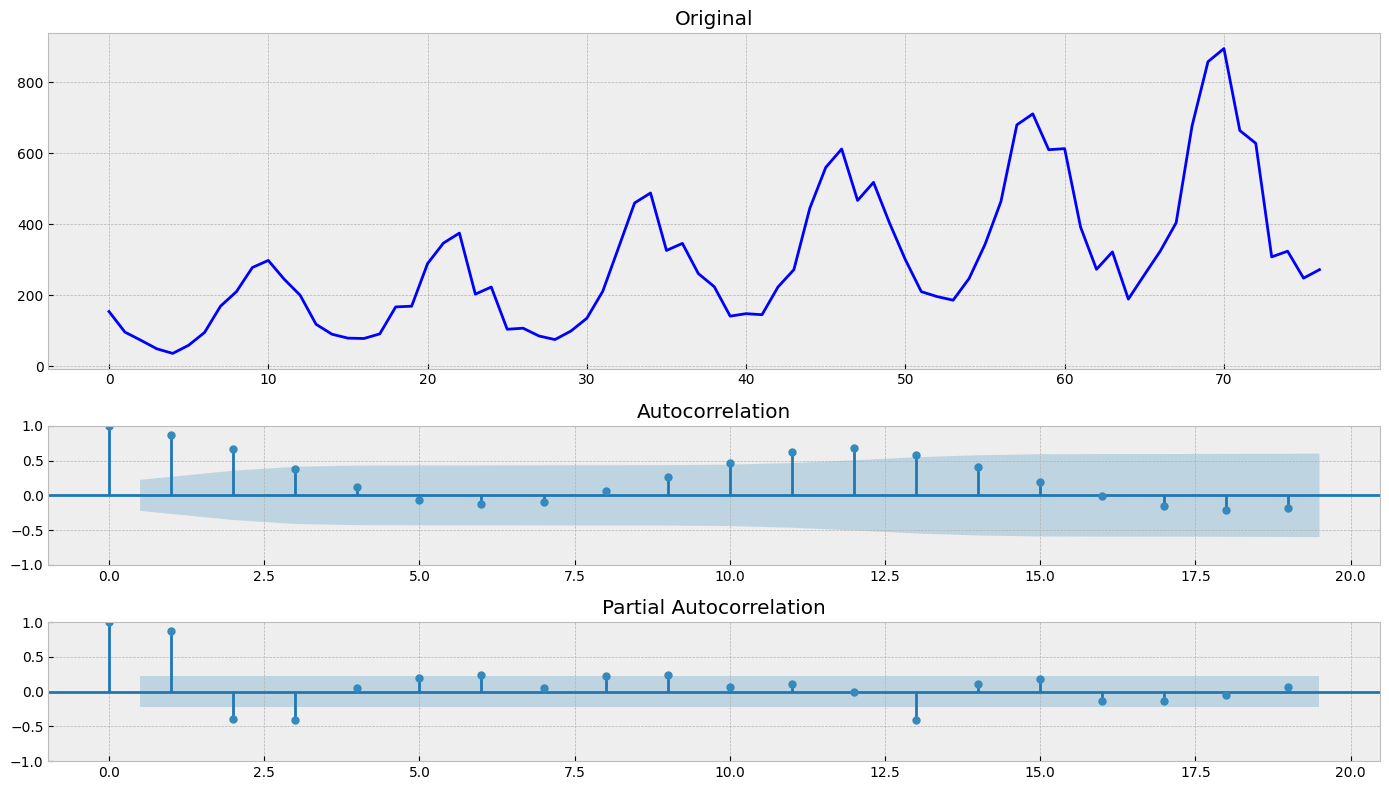

In [5]:
tsplot(sales_of_company_x)

Здесь сразу видна сезонность, поэтому решаю использовать Хольта-Винтерса, так как он прекрасно работает на рядах с сезонностью

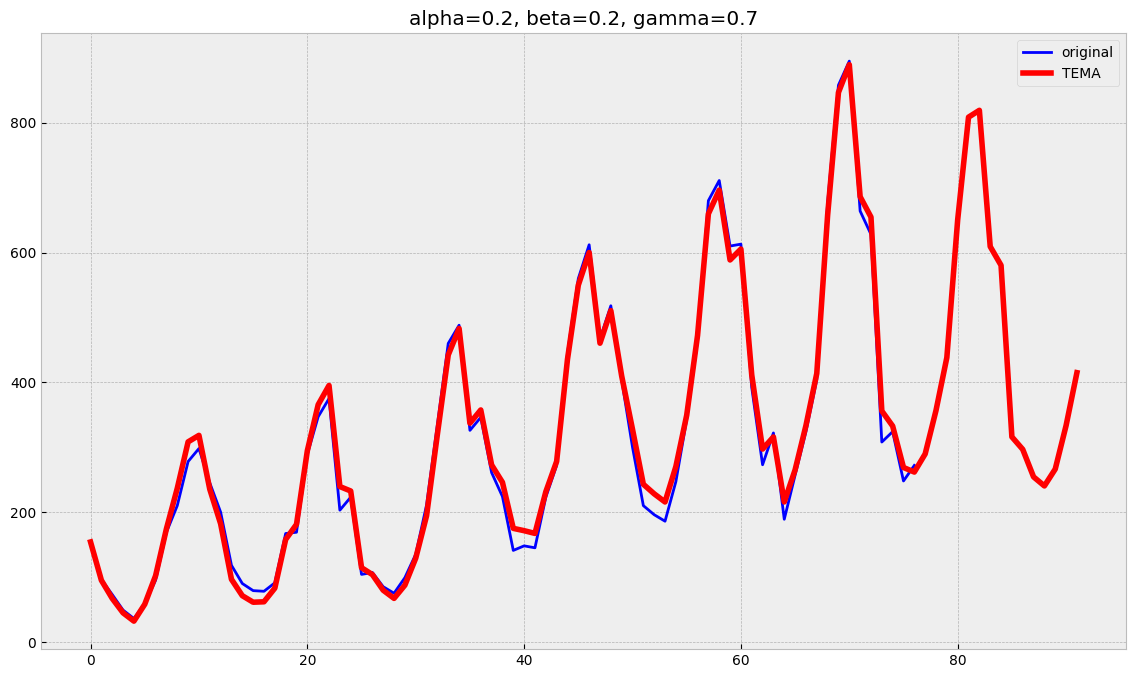

In [6]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

alpha=0.2
beta=0.2
gamma=0.7
n_periods2_pred=15

tema = triple_exponential_smoothing(sales_of_company_x, 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('sales_of_company_x')      
    plt.plot(sales_of_company_x, color='blue', label='original')
    plt.plot(tema, color='red', linewidth=4, label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()


Делаем проверку кроссвалидацией

In [7]:

train_size=round(len(sales_of_company_x)*.7)
test_size=round(len(sales_of_company_x)*.25)

In [8]:
train, test, val = sales_of_company_x[:train_size], sales_of_company_x[train_size:train_size+test_size], \
    sales_of_company_x[train_size+test_size:]

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4053.910087580052
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.95852282e-03,  2.00088834e-03, -2.10137108e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 19
     njev: 27
   status: 0
  success: True
        x: array([0.15545088, 0.08799078, 1.        ])


По результатам оптимизации видно, что оптимальные значения параметров alpha=0.155, beta=0.087, gamma=1
Но я когда выставляла руками, несколь постесьянлась ставить гамму равную 1 

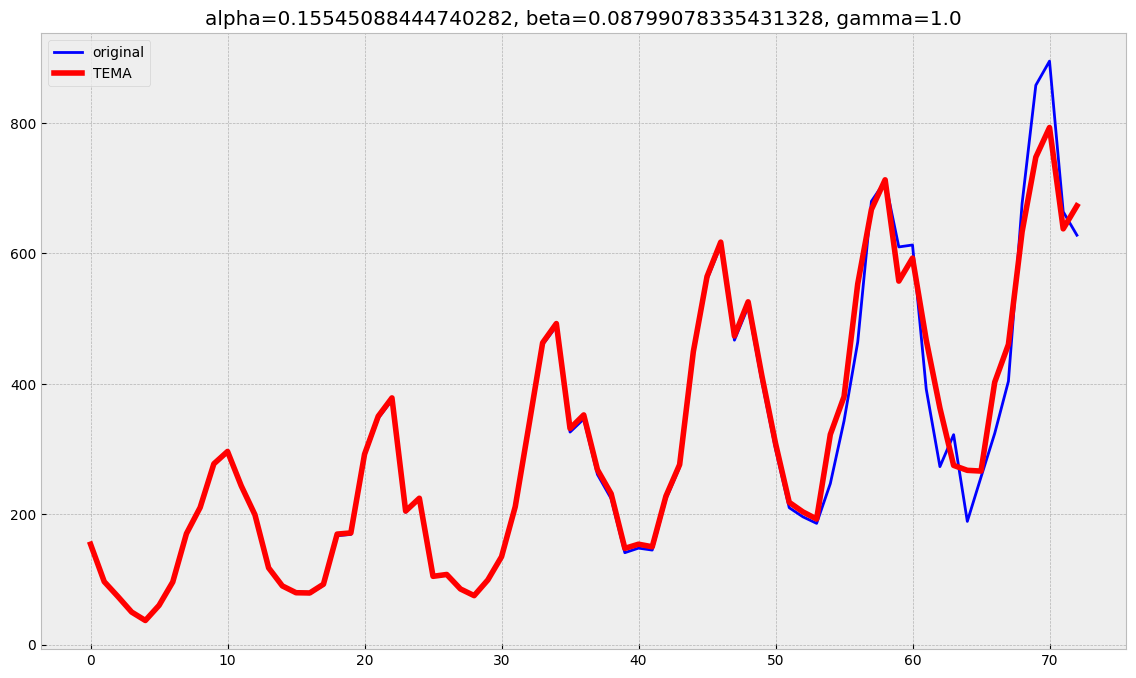

In [9]:
tema = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('sales_of_company_x')      
    plt.plot(sales_of_company_x[:train_size+test_size], color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [10]:
train, val = sales_of_company_x[:train_size], sales_of_company_x[train_size:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(sales_of_company_x):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.050385997512212434
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.02521897e-05, -1.21687382e-05,  1.03250741e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 224
      nit: 46
     njev: 56
   status: 0
  success: True
        x: array([0.07282622, 0.21128708, 0.96216782])


По результатам оптимизации видно, что оптимальные значения параметров alpha=0.07, beta=0.21, gamma=0.96

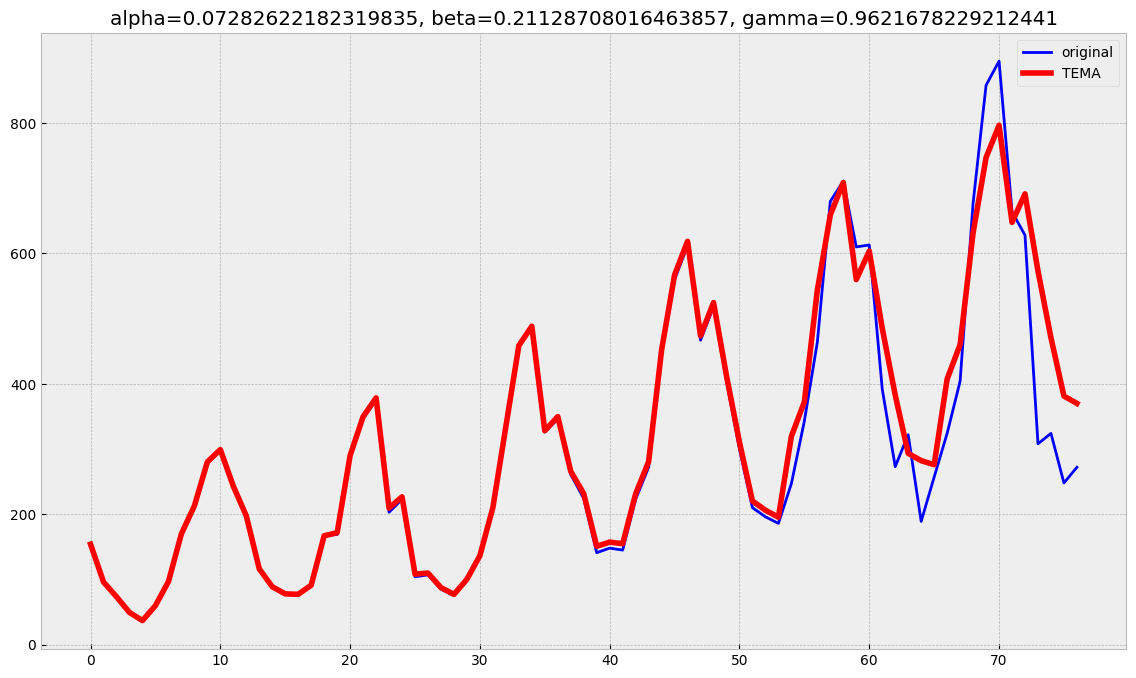

In [11]:
tema = triple_exponential_smoothing(sales_of_company_x[:train_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('sales_of_company_x')      
    plt.plot(sales_of_company_x, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [12]:
r2_score(y_pred=tema, y_true=sales_of_company_x)

0.9314659232333506

Ну вроде неплохой результат 

<h1>Стационарный временной ряд</h1>

In [13]:
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv").Deg

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


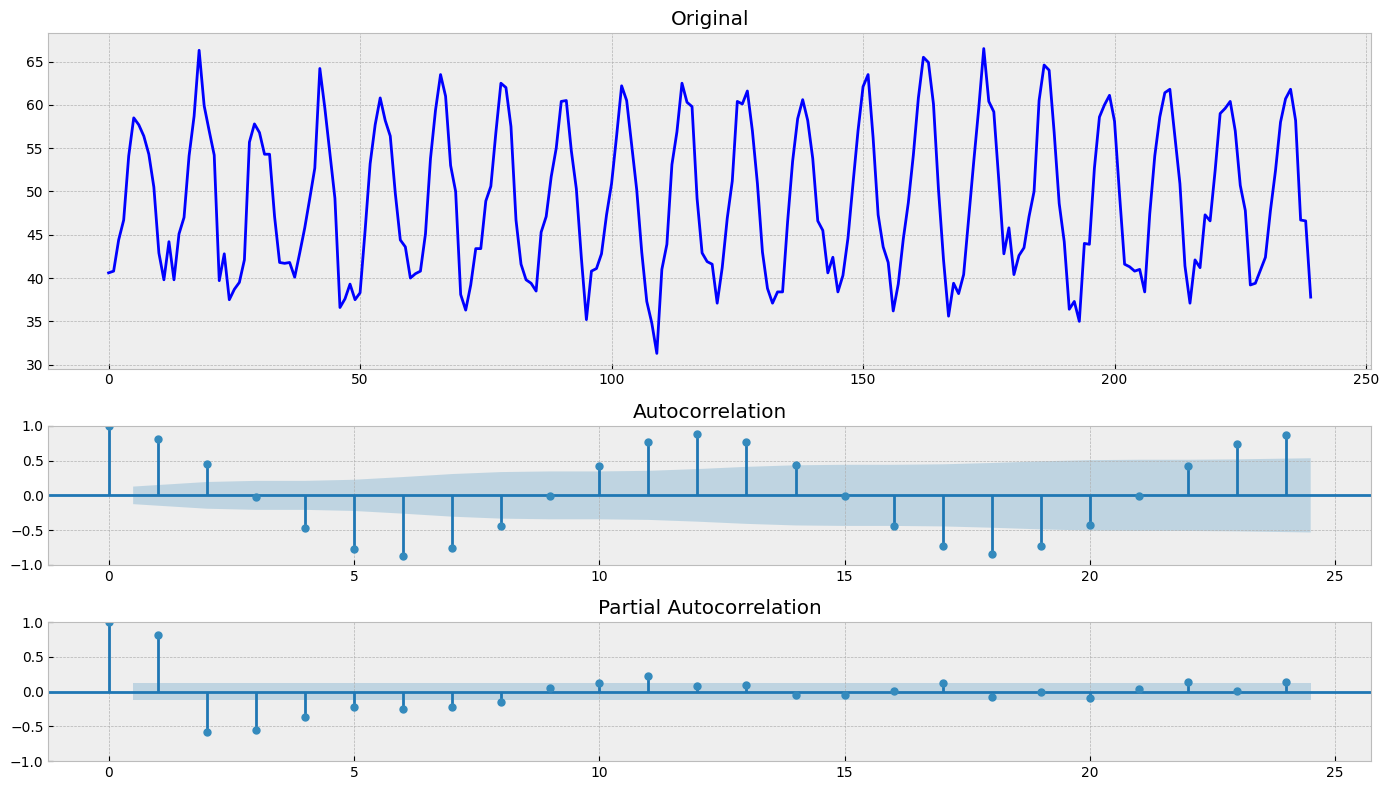

In [14]:
tsplot(mean_monthly_temp)

Видим сезонность, берем снова TEMA, так она лучше на ней отработает, плюс тут тренда явного нет 

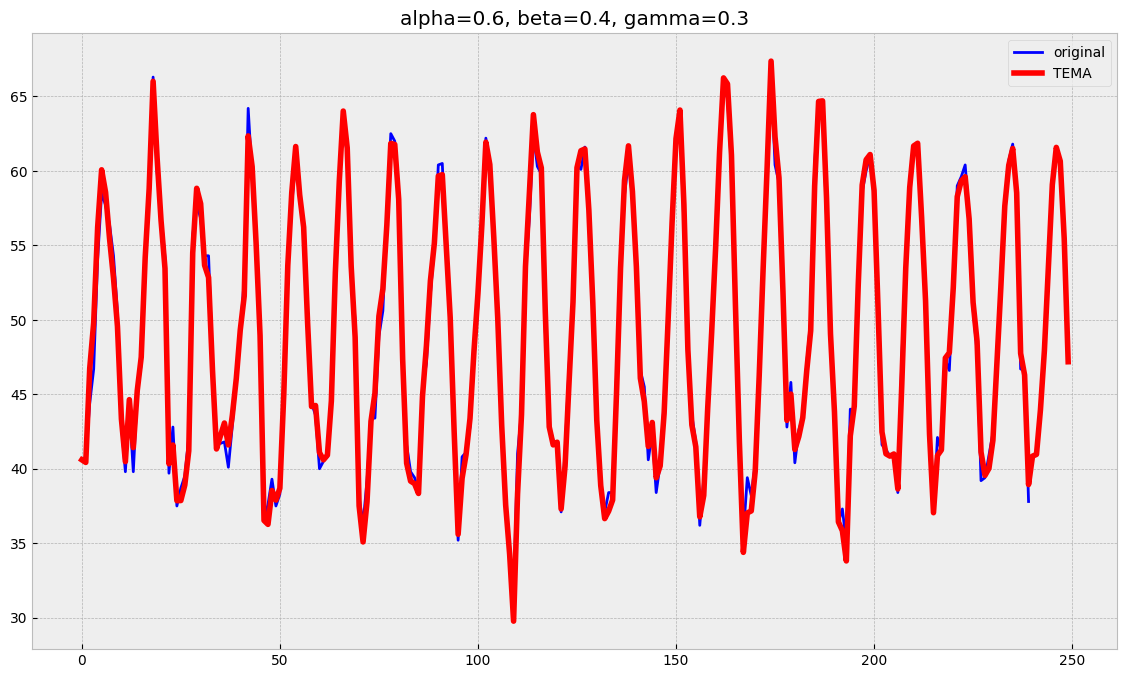

In [15]:
alpha=0.6
beta=0.4
gamma=0.3
n_periods2_pred=10

tema = triple_exponential_smoothing(mean_monthly_temp[:], 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
#     plt.title('mean_monthly_temp')      
    plt.plot(mean_monthly_temp, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()


In [59]:

train, val = mean_monthly_temp[:train_size], mean_monthly_temp[train_size:]

In [60]:

def mse_cross_val(X,):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    k=0
    for train_split, test_split in split.split(mean_monthly_temp):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
        k+=1
#     print(k,np.mean(np.array(errors)))
        
    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0.6,0.4,0.3], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 7.74172669166651e-09
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.47099976e-07, -4.60341163e-06,  2.50246601e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 320
      nit: 60
     njev: 80
   status: 0
  success: True
        x: array([0.05752688, 0.19083253, 0.91195908])


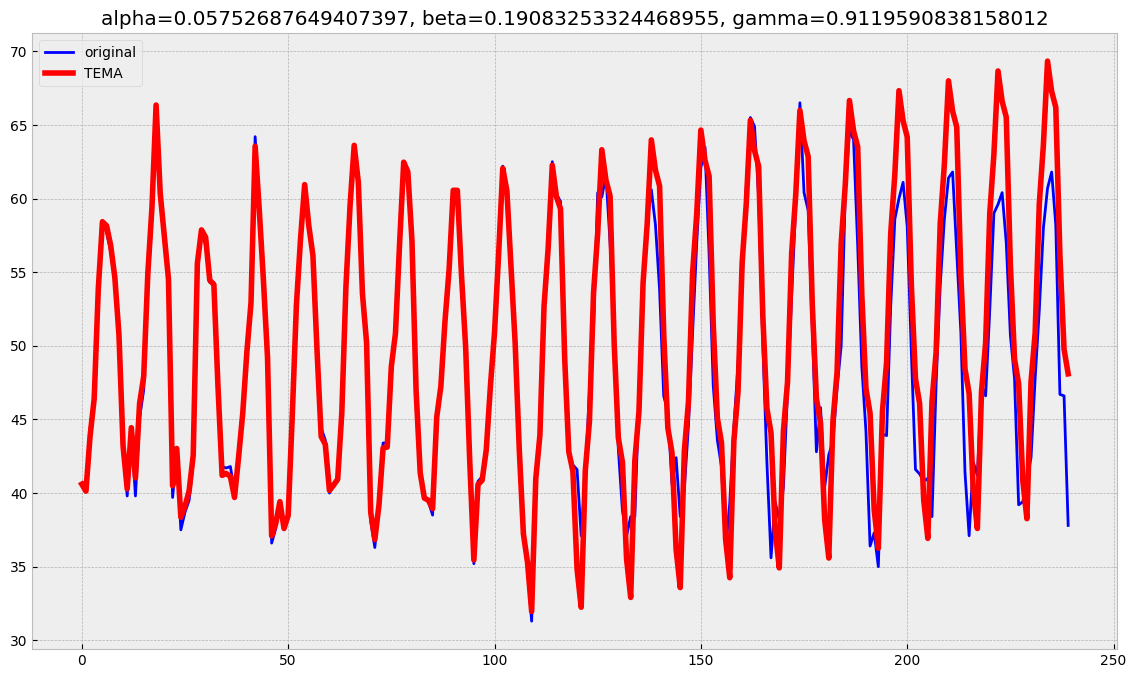

In [61]:
tema = triple_exponential_smoothing(mean_monthly_temp[:train_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('mean_monthly_temp')      
    plt.plot(mean_monthly_temp, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [62]:
r2_score(y_pred=tema, y_true=mean_monthly_temp)

0.8603459906565437